# Picard-less Bach

J.S. Bach endet oft Stücke in Moll mit einem Dur-Akkord, eine sogenannte "Picardsche Terz". Aber wie oft macht er es andersrum? Das werden wir anhand seine Chorale herausfinden.

In [1]:
from music21 import *

In [2]:
# Den Corpus nach Bach durchsuchen
corpus.search('bach')

<music21.metadata.bundles.MetadataBundle {564 entries}>

Corpushinweis: Manche der Einträge sind Dubletten. Wenn wir nach MusicXML (.xml bzw. .xml) suchen, dann können wir die zu, Großteil herausfiltern.

In [3]:
corpus.search('bach', fileExtensions='xml')

<music21.metadata.bundles.MetadataBundle {412 entries}>

Wesentlich näher an der Zahl der Bachchoräle. Die Genauigkeit soll uns reichen.

Zuerst probieren wir an einem Stück aus. Z.B. das Erste in der Liste.

In [4]:
chorales = corpus.search('bach', fileExtensions='xml')
chorales[0]

<music21.metadata.bundles.MetadataEntry: bach_bwv1_6_mxl>

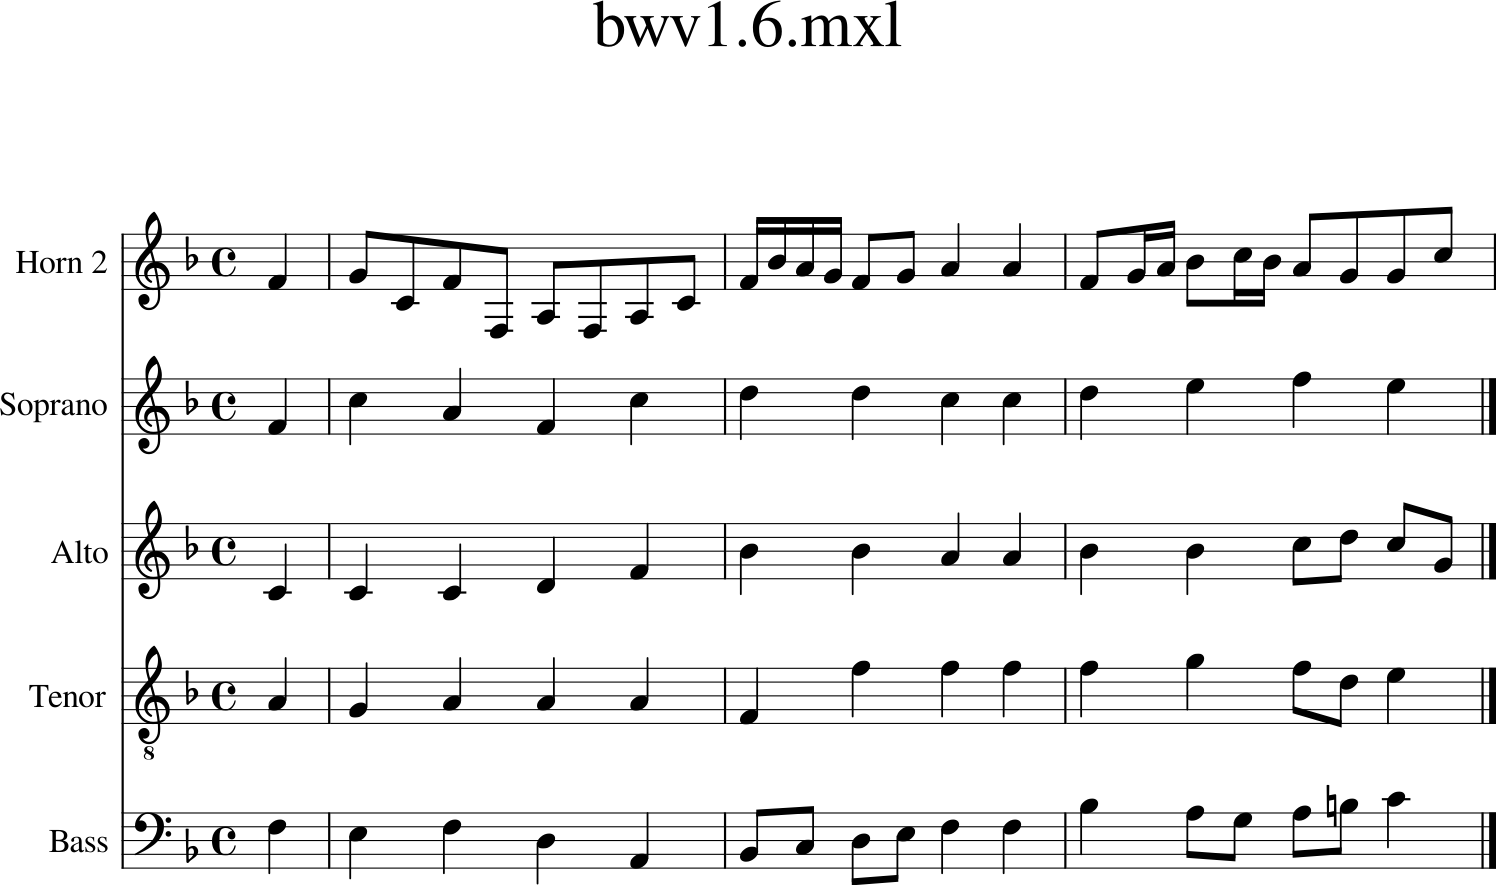

In [5]:
bwv1 = chorales[0].parse()
bwv1.measures(0, 3).show()

Es scheint in F-Dur zu sein, überprüfen wir das.

In [6]:
bwv1.analyze('key')

<music21.key.Key of F major>

Wir scheinen Recht zu haben. Aber da wir nach Stücken in Moll suchen ist dieses für uns irrelevant.

Dann schauen wir uns einfach die ersten Stücke an und lassen uns die in Moll ausgeben.

In [7]:
for i, chorale in enumerate(chorales[:20]):
    cScore = chorale.parse()
    if cScore.analyze('key').mode == 'minor':
        print(i, chorale)

1 <music21.metadata.bundles.MetadataEntry: bach_bwv10_7_mxl>
2 <music21.metadata.bundles.MetadataEntry: bach_bwv101_7_mxl>
3 <music21.metadata.bundles.MetadataEntry: bach_bwv102_7_mxl>
4 <music21.metadata.bundles.MetadataEntry: bach_bwv103_6_mxl>
6 <music21.metadata.bundles.MetadataEntry: bach_bwv108_6_mxl>
8 <music21.metadata.bundles.MetadataEntry: bach_bwv110_7_mxl>
9 <music21.metadata.bundles.MetadataEntry: bach_bwv111_6_mxl>
12 <music21.metadata.bundles.MetadataEntry: bach_bwv113_8_mxl>
13 <music21.metadata.bundles.MetadataEntry: bach_bwv114_7_mxl>


Das sieht doch gut aus. Nun nehmen wir das erste in Moll und untersuchen es.

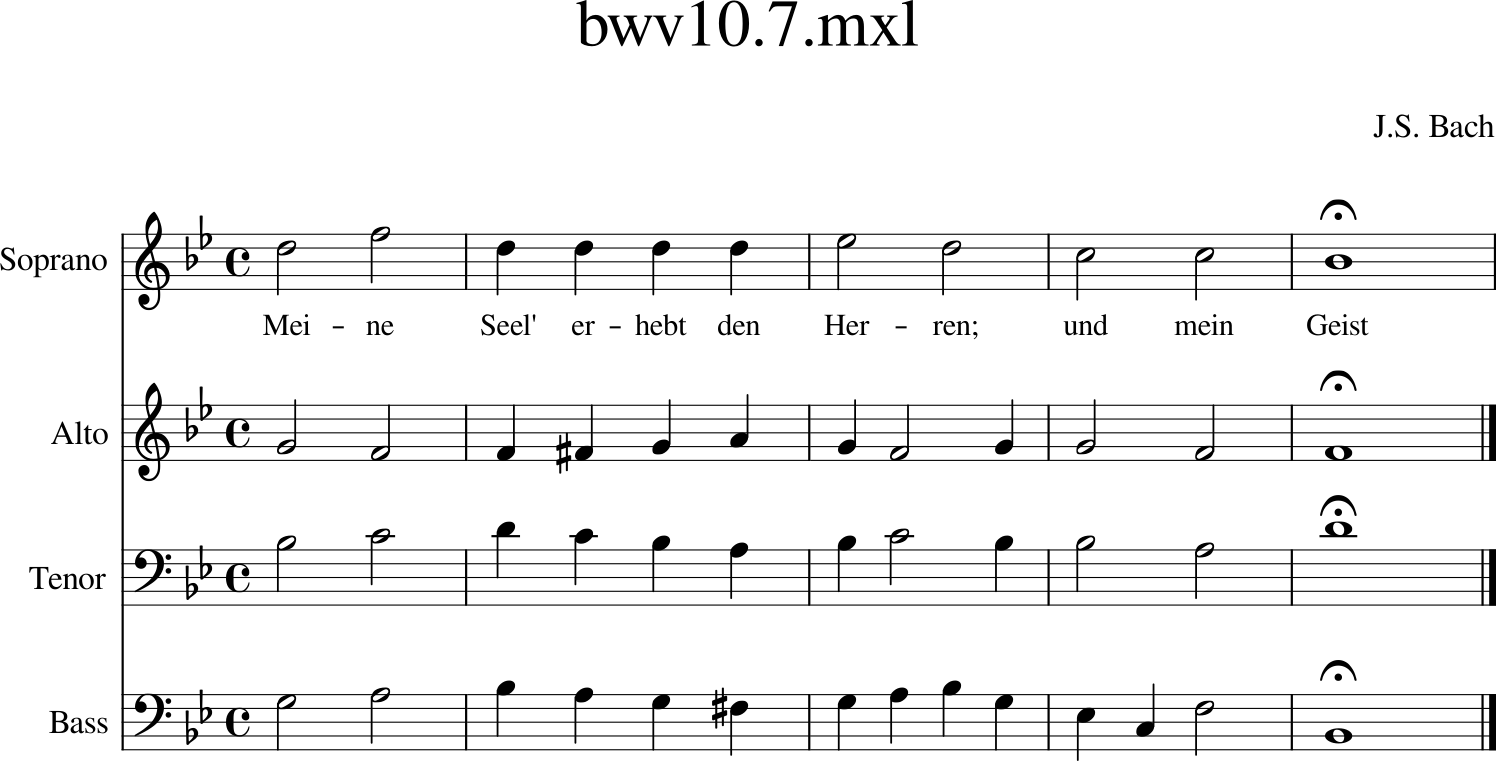

In [8]:
bwv10 = corpus.parse('bwv10')
bwv10.measures(0, 5).show()

Sieht nach G-Moll aus. Schauen wir uns das Ende an.

In [9]:
soprano = bwv10.parts[0]
len(soprano.getElementsByClass('Measure'))

22

22 Takte, also schauen wir uns die letzten beiden an.

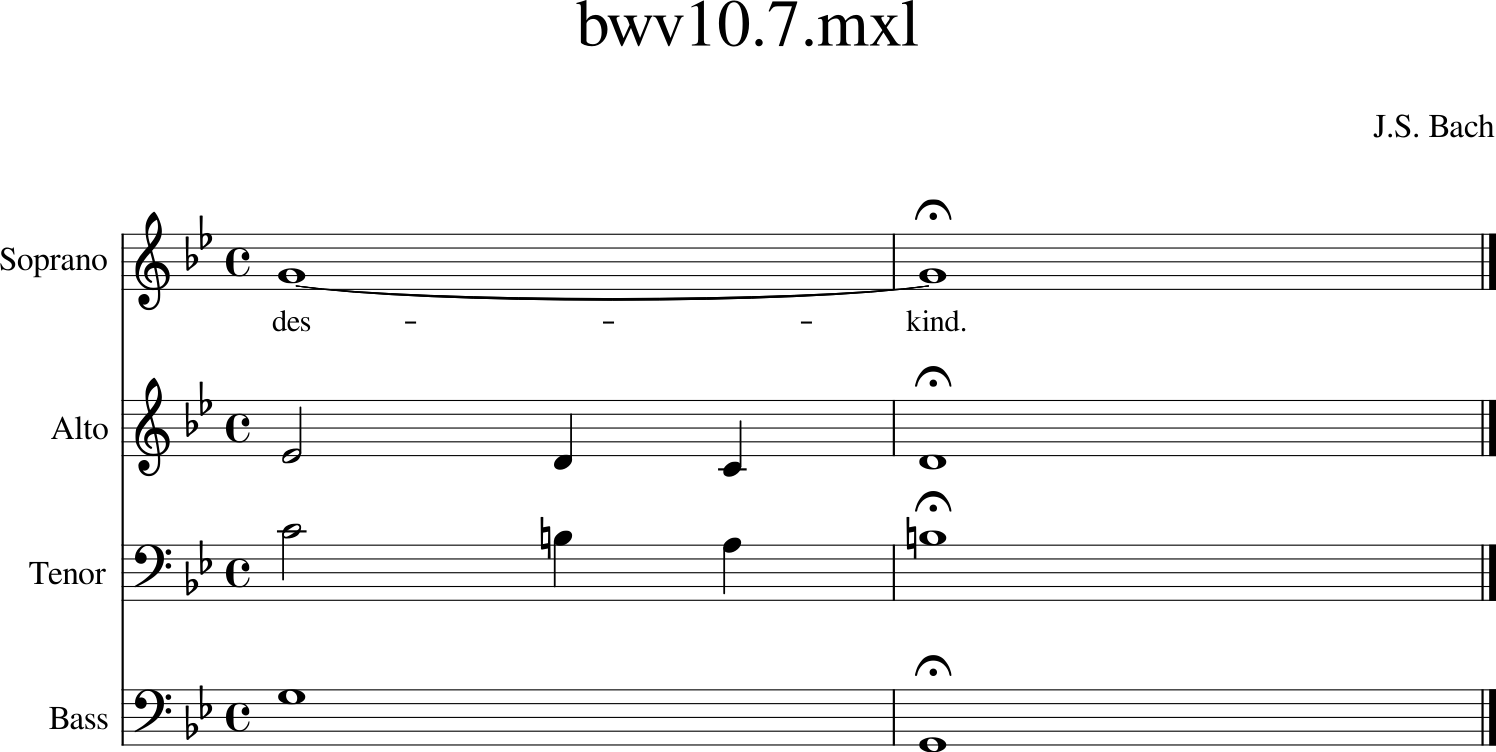

In [10]:
bwv10.measures(21, 22).show()

Sieht nach einer astreinen Picardschen Terz aus. (Jean-Luc wäre stolz...)

Nun schauen wir, wie wir den Letzten Akkord analysieren können. Dazu nehmen wir die letzten Töne aus jeder Stimme.

In [11]:
lastPitches = []

for part in bwv10.parts:
    lastPitch = part.pitches[-1]
    lastPitches.append(lastPitch)

lastPitches

[<music21.pitch.Pitch G4>,
 <music21.pitch.Pitch D4>,
 <music21.pitch.Pitch B3>,
 <music21.pitch.Pitch G2>]

Hinweis: Das funktioniert, da Bach i.d.R. Stimmen nicht früher aufhören lässt und keine Pausen am Ende hat. Wäre das der Fall, dann müsste man das anders lösen.

Nun machen wir aus den Noten einen Akkord mit der Länge einer ganzen Note.

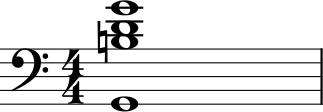

In [12]:
c = chord.Chord(lastPitches)
c.duration.type = 'whole'
c.show()

Sehr unübersichtlich, besser wäre in enger Lage.

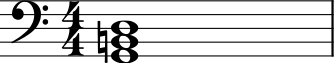

In [13]:
cClosed = c.closedPosition()
cClosed.show()

Viel besser. Sieht nach einem G-Dur Akkort aus. Sieht music21 das genauso?

In [14]:
cClosed.isMajorTriad()

True

In [15]:
cClosed.root()

<music21.pitch.Pitch G2>

Ja, music21 stimmt da mit uns überein.

Nun bauen wir Teile des bisherigen Codes und machen eine Funktion daraus und schauen, ob sie so funktioniert, wie wir das wollen.

In [16]:
def getLastChord(score):
    lastPitches = []
    
    for part in score.parts:
        lastPitch = part.pitches[-1]
        lastPitches.append(lastPitch)
    
    c = chord.Chord(lastPitches)
    c.duration.type = 'whole'
    
    cClosed = c.closedPosition()
    return cClosed

In [17]:
getLastChord(bwv10)

<music21.chord.Chord G2 B2 D3>

Scheint wie erwartet zu funktionieren.

Nun schreiben wir eine Routine, die einen Score als Parameter nimmt und schaut, ob er relevant ist. Relevant wäre:
* Stück steht in Moll
* letzter Akkord ist in Dur
* der Grundton des letzten Akkordes ist jener der Tonika

Falls das zutreffen sollte geben wir den letzten Akkord zurück, falls nicht `False`.

In [18]:
def isRelevant(score):
    analyzedKey = score.analyze('key')
    if analyzedKey.mode != 'minor':
        return False
    lastChord = getLastChord(score)
    if lastChord.isMinorTriad() is False:
        return False
    if lastChord.root().name != analyzedKey.tonic.name:
        return False
    return lastChord

Hinweis: Am Anfang der Funktion haben wir das ergebnis von `analyze('key')` in einer Variablen gespeichert, damit die Funktion nicht mehrmals aufgerufen werden muss. Täten wir das, hätten wir bei vielen Stücken deutlich schlechtere Performanz.

Nun schauen wir uns einige Stücke an und schauen welche relevant sind. Dafür speichen wir alle letzten Akkorde in einem neuen Stream und fügen den Namen (bzw. Dateinamen) des Stückes als lyric-Objekt hinzu.

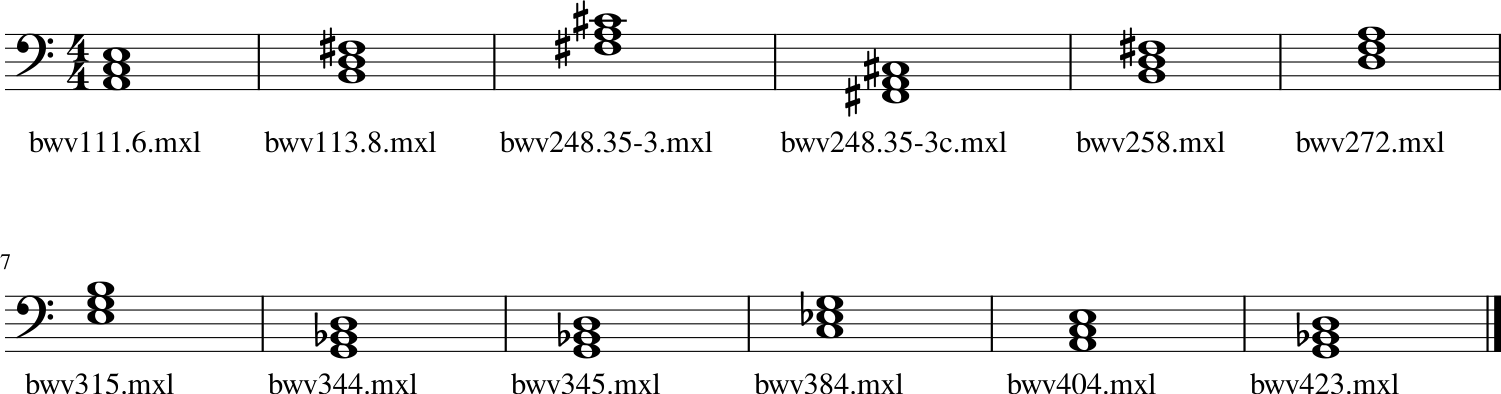

In [19]:
relevantStream = stream.Stream()
relevantStream.append(meter.TimeSignature('4/4'))

for chorale in chorales:
    score = chorale.parse()
    falseOrChord = isRelevant(score)
    if falseOrChord is not False:
        theChord = falseOrChord
        theChord.lyric = score.metadata.title
        relevantStream.append(theChord)

relevantStream.show()

Das sind spannende Ergebnisse, aber die "richtige" Wissenschaft beginnt hier erst. Wenn man die Stücke genauer anschaut, kommt man auf interessante Ergebnisse:
* BWV 111.6 ist möglicherweise nicht von Bach
* BWV 248 ist das Weihnachtsoratorium; im Originalmanuskript ist es ein Moll-Akkord (möglicherweise formbedingt)
* die restlichen haben eine BWV-Nummer über 150, sprich sie sind nicht Teil eine Kantate, möglicherweise sind sie Kompositionsübungen. Es wurde auch schon in Zweifel gestellt, dass die überhaupt von Bach wären.

# Hausaufgabe (bis 06.07.2020)

Die Choräle von Bach nach der Tonfolge B-A-C-H durchsuchen und die Funde in einem neuen Stream speichern (jede der vier Noten als Viertelnote, BWV-Name des Stücks & Stimme & Takt (der ersten Note) als Lyric-Element der ersten Note). 